In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2021-06-26 11:21:12--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz.21’

Software_5.json.gz. 100%[===================>]   5.09M  4.08MB/s    in 1.2s    

2021-06-26 11:21:13 (4.08 MB/s) - ‘Software_5.json.gz.21’ saved [5339013/5339013]



[PPT link](https://drive.google.com/file/d/16herCTB4zE5GF6fBJJAVwny7z8pliCP-/view?usp=sharing)


In [ ]:
import os
import json
import gzip
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn
from urllib.request import urlopen
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data = []
with gzip.open('Software_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

data_df = pd.DataFrame.from_dict(data)


data_df['text'] =  data_df['reviewText'] + data_df['summary']
# data_df['count'] = data_df['text'].str.split().str.len()

data_df['is_bad_review'] = data_df['overall'].apply(lambda x:1 if x < 3 else 0)  
data_df.drop(columns = ['vote', 'image','verified','reviewerID','unixReviewTime','style','reviewerName','reviewTime','asin','reviewText','summary'],axis=1,inplace=True)
#data_df.head()

In [ ]:
# sum=data_df['count'].sum()
# print(sum)

In [ ]:
#Checking the ratio of positive to negative reviews in total

#data_df["is_bad_review"].value_counts(normalize = True) 
#data_df["text"].head(10)

0                  A solid overview of Dreamweaver CS5
1                                         A good value
2    This is excellent software for those who want ...
3    A Fantastic Overview of Dream Weaver and Web D...
4                                 Excellent Tutorials!
5                                           Excellent.
6                    excellent video training material
7         Great Video for a Difficult at Times Program
8                        Excellent value for the price
9               Buy this with your copy of Dreamweaver
Name: text, dtype: object

In [ ]:
#text pre-processing

from nltk.corpus import stopwords    
from textblob import Word

stoplist = set(stopwords.words('english'))


def cleaning_text(df):
    df['text'] = df['text'].str.lower().str.replace('[^\w\s]','')                                                               # Punctuation Removal
    df['text'] = df['text'].apply( lambda x: ' '.join([w for w in str(x).split() if w not in stoplist]) )                       # Removing stopwords
    df['text'] = df['text'].apply( lambda x:' '.join(x for x in x.split(" ") if not any( c.isdigit() for c in x) ) )             # Numbers Removal
    df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))                        # Lemmatization
    df['text'] = df['text'].apply( lambda x:' '.join(x for x in x.split(" ") if len(x) > 1) )                               # Single letter Words Removal


cleaning_text(data_df)

#data_df["text"].head(10)

# Pre-processing of the dataset is done . 

0                           solid overview dreamweaver
1                                           good value
2    excellent software want use crash refresher co...
3    fantastic overview dream weaver web design gen...
4                                   excellent tutorial
5                                            excellent
6                    excellent video training material
7                   great video difficult time program
8                                excellent value price
9                                 buy copy dreamweaver
Name: text, dtype: object

In [ ]:
# data_df['count'] = data_df['text'].str.split().str.len()
# sum=data_df['count'].sum()
# print(sum)

In [ ]:
# tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(data_df["text"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = data_df.index

data_df = pd.concat([data_df, tfidf_df], axis=1)

#data_df.head()

(-0.5, 1199.5, 599.5, -0.5)

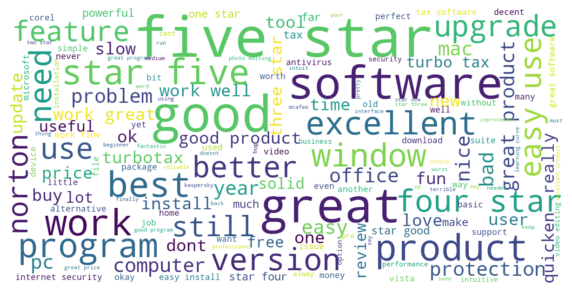

In [ ]:
wordcloud = WordCloud(background_color='white',max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42).generate(' '.join(data_df['text']))   #WordCloud of the reviews

fig = plt.figure(1, figsize = (10, 10))
fig.suptitle(None, fontsize = 10)
fig.subplots_adjust(top = 2.3)

plt.axis("off")
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.show()

In [ ]:
#Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()
data_df['sentiment_score'] = data_df['text'].apply(lambda x: sid.polarity_scores(x))
data_df = pd.concat([data_df.drop(['sentiment_score'], axis=1), data_df['sentiment_score'].apply(pd.Series)], axis=1)

#data_df.head()


In [ ]:
#ma= data_df.max()['compound']
#mi=data_df.min()['compound']
#print(ma)

In [ ]:
#Distribution of sentiment score
import seaborn as sns

for x in [0, 1]:
    subset = data_df[data_df['is_bad_review'] == x]
    
    # Density plot of data set
    if x == 0:
        label = "Good reviews"
        #sns.kdeplot(subset['compound'],label ='Good Reviews')
    else:
        label = "Bad reviews"
        #sns.kdeplot(subset['compound'],label = 'Bad Reviews')
        

    #plt.legend()
    #plt.title("Density plot for compound score")
   

In [ ]:
#Training the data set

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.svm import SVC
# from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics

ignore_cols = ['is_bad_review', 'overall', 'text']
features = [c for c in data_df.columns if c not in ignore_cols]
#print(features)
#print(len(features))

#Splitting the dataset into train and test 80-20
X_train, X_test, y_train, y_test = train_test_split(data_df[features], data_df['is_bad_review'], test_size = 0.20, random_state = 42)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Predicting the sentiment for the test-set
y_test_pred = rfc.predict(X_test)

score = metrics.accuracy_score(y_test, y_test_pred)
#print(classification_report(y_test,y_test_pred))
print(score)



0.8852010933229207


In [ ]:
#Show feature importance
#feature_importances_df = pd.DataFrame({"feature": features, "importance": rfc.feature_importances_}).sort_values("importance", ascending = False)
#feature_importances_df.head(10)
